In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme(style='white', palette='mako')

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
date_columns = ['timestamp', 'inference_time']
categoric_columns = ['month', 'week', 'day_of_week', 'day', 'hour']
dtype_categoric = dict([(c,'category') for c in categoric_columns])

data = pd.read_csv('../../data/yellow_trip_demand_forecasting_dataset.csv', dtype=dtype_categoric, parse_dates=date_columns)

In [3]:
data

,timestamp,demand,inference_time,month,week,day_of_week,day,hour,holiday,days_since_last_holiday,...,total_trip_duration_in_last_3_days.1,total_trip_duration_3_days_ago.1,total_trip_duration_in_last_4_days.1,total_trip_duration_4_days_ago.1,total_trip_duration_in_last_5_days.1,total_trip_duration_5_days_ago.1,total_trip_duration_in_last_6_days.1,total_trip_duration_6_days_ago.1,total_trip_duration_in_last_7_days.1,total_trip_duration_7_days_ago.1
0,2011-01-15 00:00:00,28409.0,2011-01-08 00:00:00,1,1,5,8,0,False,8.000000,...,950918012.0,6836187.0,1.230411e+09,5721764.0,1.479726e+09,6222412.0,1.586190e+09,5115966.0,1.715639e+09,9741493.0
1,2011-01-15 01:00:00,23681.0,2011-01-08 01:00:00,1,1,5,8,1,False,8.041667,...,958369721.0,4102893.0,1.238977e+09,3548101.0,1.487792e+09,4030499.0,1.595362e+09,4130277.0,1.720185e+09,11434865.0
2,2011-01-15 02:00:00,19960.0,2011-01-08 02:00:00,1,1,5,8,2,False,8.083333,...,965809127.0,2627485.0,1.246971e+09,2298391.0,1.495304e+09,2623408.0,1.602774e+09,3497604.0,1.720293e+09,9972823.0
3,2011-01-15 03:00:00,15359.0,2011-01-08 03:00:00,1,1,5,8,3,False,8.125000,...,972127163.0,1902728.0,1.253619e+09,1578918.0,1.501626e+09,1723150.0,1.608222e+09,2964597.0,1.719265e+09,8293949.0
4,2011-01-15 04:00:00,9962.0,2011-01-08 04:00:00,1,1,5,8,4,False,8.166667,...,975878175.0,1697241.0,1.257693e+09,1567214.0,1.505556e+09,1992104.0,1.610911e+09,2325073.0,1.716625e+09,5934715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104099,2022-11-30 19:00:00,7290.0,2022-11-23 19:00:00,11,47,2,23,19,False,11.833333,...,367206722.0,4469438.0,4.638584e+08,7212390.0,5.669687e+08,6894392.0,6.792142e+08,6913530.0,7.945942e+08,7046728.0
104100,2022-11-30 20:00:00,6897.0,2022-11-23 20:00:00,11,47,2,23,20,False,11.875000,...,367552605.0,3341538.0,4.614613e+08,5902951.0,5.648896e+08,5809434.0,6.771160e+08,6066074.0,7.923628e+08,5792558.0
104101,2022-11-30 21:00:00,7023.0,2022-11-23 21:00:00,11,47,2,23,21,False,11.916667,...,369282934.0,2746214.0,4.606302e+08,5226713.0,5.641521e+08,5584354.0,6.761218e+08,6422138.0,7.916421e+08,5568959.0
104102,2022-11-30 22:00:00,6380.0,2022-11-23 22:00:00,11,47,2,23,22,False,11.958333,...,370657253.0,2680095.0,4.595241e+08,5533508.0,5.626882e+08,5812714.0,6.738202e+08,5710735.0,7.901937e+08,5193649.0


In [4]:
train_start_date = data['inference_time'].min()
train_end_date = data['inference_time'].min() + pd.DateOffset(months=15)
test_end_date = train_end_date + pd.DateOffset(months=3)
prod_end_date = data['inference_time'].max()

# Create data partition
data['partition'] = pd.cut(
    data['inference_time'],
    bins= [train_start_date,
           train_end_date,
           test_end_date,
           prod_end_date],
    right=False,
    labels= ['train', 'test', 'prod']
)

# Set target and features
target = 'demand'
features = [col for col in data.columns if col not in [target, 'partition'] + date_columns]

# Split the data
X_train = data.loc[data['partition'] == 'train', features]
y_train = data.loc[data['partition'] == 'train', target]

X_test = data.loc[data['partition'] == 'test', features]
y_test = data.loc[data['partition'] == 'test', target]

X_prod = data.loc[data['partition'] == 'prod', features]
y_prod = data.loc[data['partition'] == 'prod', target]

## Exploring the training data

In [5]:
df = data.loc[data['partition'] == 'train', ['timestamp', 'demand']]
df['day'] = df['timestamp'].dt.to_period('D')

df1 = df.copy()
df1 = df1.groupby(['day'])['demand'].sum() / 1e3
df1.index = df1.index.to_timestamp()
df1 = df1.reset_index()
df1['day_of_week'] = df1['day'].dt.dayofweek + 1
df1['month'] = df1['day'].dt.month


In [6]:
df1['demand'].median()

490.488

In [7]:
pd.qcut(df1['demand'], q=4)

0                 (453.318, 490.488]
1      (29.026999999999997, 453.318]
2      (29.026999999999997, 453.318]
3      (29.026999999999997, 453.318]
4                 (453.318, 490.488]
                   ...              
451    (29.026999999999997, 453.318]
452    (29.026999999999997, 453.318]
453               (453.318, 490.488]
454               (490.488, 525.365]
455               (490.488, 525.365]
Name: demand, Length: 456, dtype: category
Categories (4, interval[float64, right]): [(29.026999999999997, 453.318] < (453.318, 490.488] < (490.488, 525.365] < (525.365, 592.896]]

In [8]:
df1

,day,demand,day_of_week,month
0,2011-01-15,485.503,6,1
1,2011-01-16,446.699,7,1
2,2011-01-17,386.391,1,1
3,2011-01-18,442.217,2,1
4,2011-01-19,477.235,3,1
...,...,...,...,...
451,2012-04-10,449.912,2,4
452,2012-04-11,451.950,3,4
453,2012-04-12,467.201,4,4
454,2012-04-13,492.826,5,4


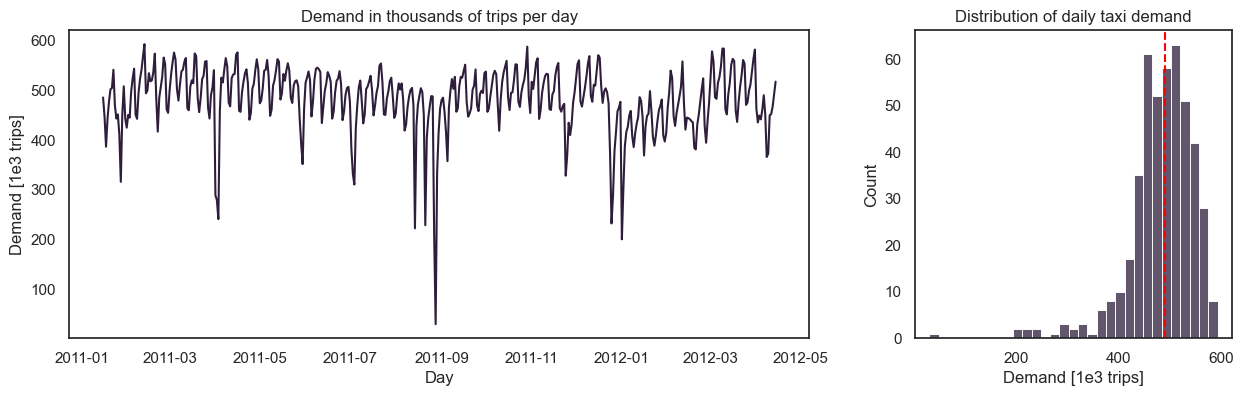

In [9]:
fig, ax = plt.subplots(1, 2, width_ratios=[70, 30], figsize=(15, 4))

sns.lineplot(data=df1, x='day', y='demand', ax=ax[0])
ax[0].set_title('Demand in thousands of trips per day')
ax[0].set_ylabel('Demand [1e3 trips]')
ax[0].set_xlabel('Day')

sns.histplot(data=df1, x='demand', ax=ax[1])
plt.axvline(df1['demand'].median(), color='r', linestyle='--')
ax[1].set_title('Distribution of daily taxi demand')
ax[1].set_xlabel('Demand [1e3 trips]')
plt.savefig('../../figures/taxi_demand_timeseries_and_distribution.svg', format='svg', bbox_inches='tight')
plt.show()

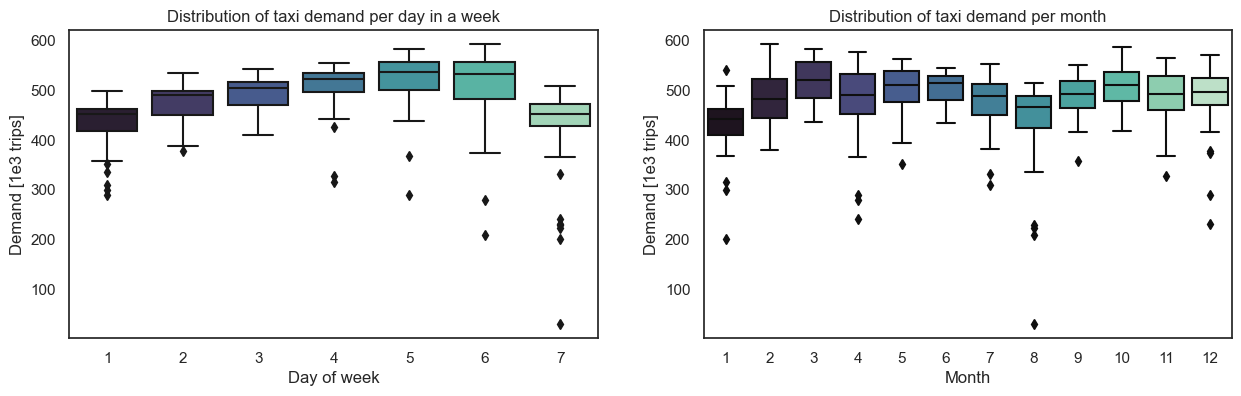

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
sns.boxplot(data=df1, x='day_of_week', y='demand', ax=ax[0], palette='mako')
ax[0].set_title('Distribution of taxi demand per day in a week')
ax[0].set_xlabel('Day of week')
ax[0].set_ylabel('Demand [1e3 trips]')

sns.boxplot(data=df1, x='month', y='demand', order=[i for i in range(1, 13)], ax=ax[1], palette='mako')
ax[1].set_title('Distribution of taxi demand per month')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Demand [1e3 trips]')
plt.savefig('../../figures/taxi_day_month_demand.svg', format='svg', bbox_inches='tight')
plt.show()

In [11]:
df2 = data.loc[data['partition'] == 'train']
df2 = df2[['timestamp', 'holiday']]
df2['day'] = df2['timestamp'].dt.to_period('D').dt.to_timestamp()
df2 = df2.drop(columns='timestamp').drop_duplicates()

In [12]:
df3 = df1.merge(df2, how='left', on='day')

In [13]:
df3

,day,demand,day_of_week,month,holiday
0,2011-01-15,485.503,6,1,False
1,2011-01-16,446.699,7,1,False
2,2011-01-17,386.391,1,1,False
3,2011-01-18,442.217,2,1,False
4,2011-01-19,477.235,3,1,False
...,...,...,...,...,...
451,2012-04-10,449.912,2,4,False
452,2012-04-11,451.950,3,4,False
453,2012-04-12,467.201,4,4,False
454,2012-04-13,492.826,5,4,False


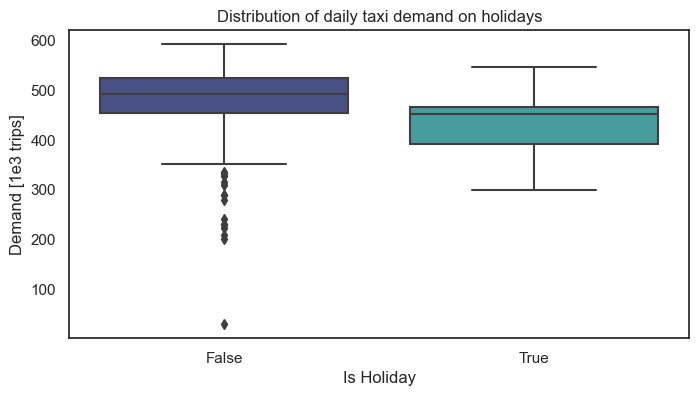

In [33]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(data=df3, x='holiday', y='demand', ax=ax, palette='mako')
ax.set_title('Distribution of daily taxi demand on holidays')
ax.set_ylabel('Demand [1e3 trips]')
ax.set_xlabel('Is Holiday')
plt.savefig('../../figures/taxi_day_holiday_demand.svg', format='svg', bbox_inches='tight')
plt.show()

## Train a model

In [15]:
from lightgbm import LGBMRegressor, plot_importance
model = LGBMRegressor(random_state=111)
model.fit(X_train, y_train)

LGBMRegressor(random_state=111)

In [16]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Evaluate the model

In [17]:
# Make baseline predictions
y_pred_train_baseline = np.ones_like(y_train) * y_train.mean()
y_pred_test_baseline = np.ones_like(y_test) * y_train.mean()

# Measure train, test and baseline performance
mape_train = mean_absolute_percentage_error(y_train, y_pred_train).round(4)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test).round(4)

mape_train_baseline = mean_absolute_percentage_error(y_train, y_pred_train_baseline).round(4)
mape_test_baseline = mean_absolute_percentage_error(y_test, y_pred_test_baseline).round(4)

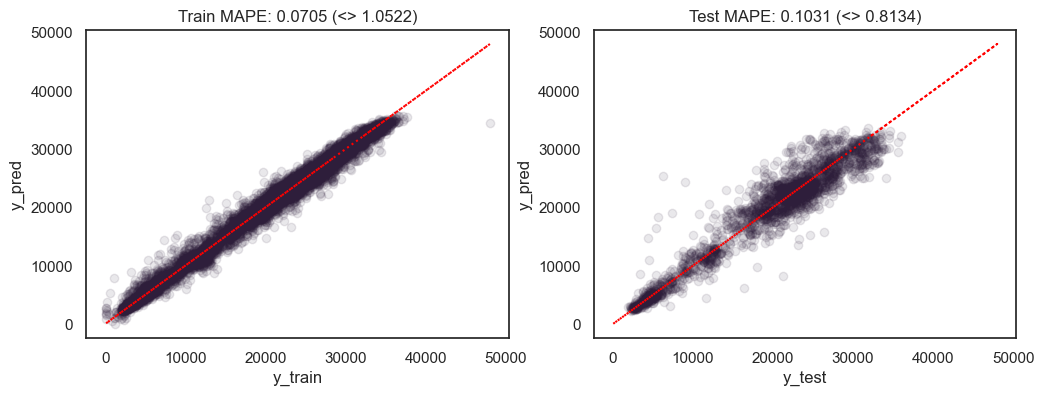

In [34]:
# Create performance report 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

upper_lim = max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())

title1 = 'Train MAPE: {} (<> {})'.format(mape_train, mape_train_baseline) 
ax1.set(title=title1, xlabel='y_train', ylabel='y_pred')
ax1.plot(y_train, y_train, color='red', linestyle=':')
ax1.scatter(y_train, y_pred_train, alpha=0.1)
# ax1.set_xlim(0, upper_lim)
# ax1.set_ylim(0, upper_lim)

title2 = 'Test MAPE: {} (<> {})'.format(mape_test, mape_test_baseline)
ax2.set(title=title2, xlabel='y_test', ylabel='y_pred')
ax2.plot(y_train, y_train, color='red', linestyle=':')
ax2.scatter(y_test, y_pred_test, alpha=0.1)
ax2.set
# ax2.set_xlim(0, upper_lim)
# ax2.set_ylim(0, upper_lim)

plt.savefig('../../figures/taxi_model_plots.svg', format='svg', bbox_inches='tight')
plt.show()

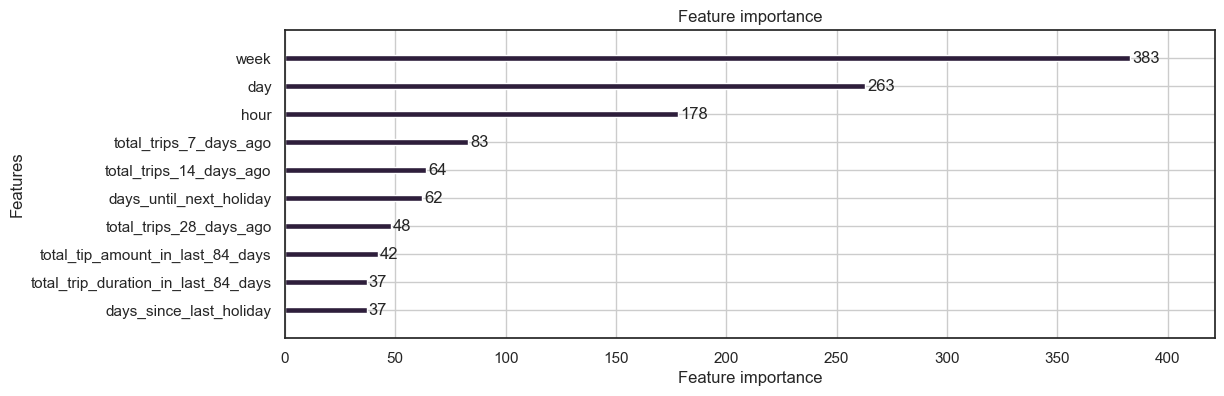

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
a = plot_importance(model, ax=ax, max_num_features=10)
# plt.savefig('fig_2.png', dpi=300)
plt.savefig('../../figures/taxi_model_feature_importance.svg', format='svg', bbox_inches='tight')
plt.show()

## Making predictions

In [20]:
data['predicted_demand'] = model.predict(data[features])

## Post-deployment model analysis

In [21]:
def vspan(ax, ax2=None):
    handles, labels = ax.get_legend_handles_labels()
    
    if len(handles) > 3:
        handles = handles[:2]
        labels = labels[:2]
    else:
        handles = handles[:1]
        labels = labels[:1]
    
    if ax2:
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles2 = handles2[1]
        labels2 = labels2[1]
        
        handles = handles + [handles2]
        labels = labels + ['mean_absolute_error']

    ax.axvspan(train_start_date, train_end_date, color='#44AF69', alpha=0.25, zorder=-10)
    legend_patch = mpatches.Patch(color='#44AF69', alpha=0.25, label='Train')
    handles.append(legend_patch)
    labels.append('Train')

    ax.axvspan(train_end_date, test_end_date, color='#F2DC5D', alpha=0.125, zorder=-10)
    legend_patch = mpatches.Patch(color='#F2DC5D', alpha=0.125, label='Test')
    handles.append(legend_patch)
    labels.append('Test')

    ax.legend(handles=handles, labels=labels)

In [24]:
df = data[['timestamp', 'demand', 'predicted_demand']].copy()
df['month'] = df['timestamp'].dt.to_period('M')
df['week'] = df['timestamp'].dt.to_period('W')

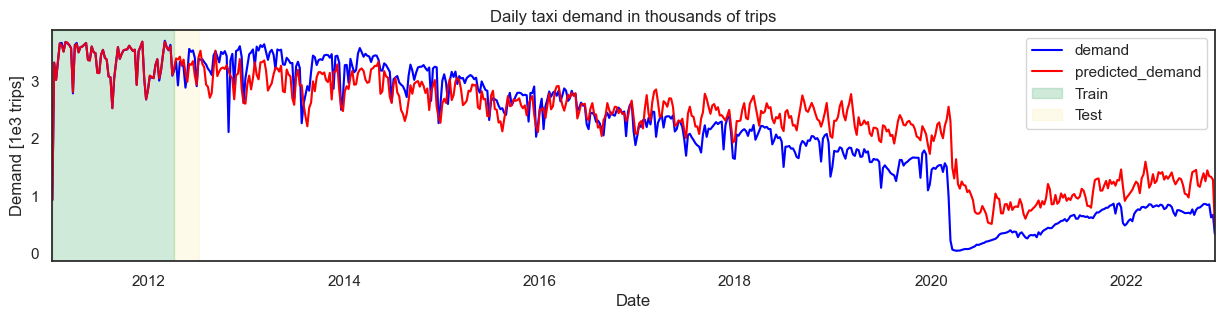

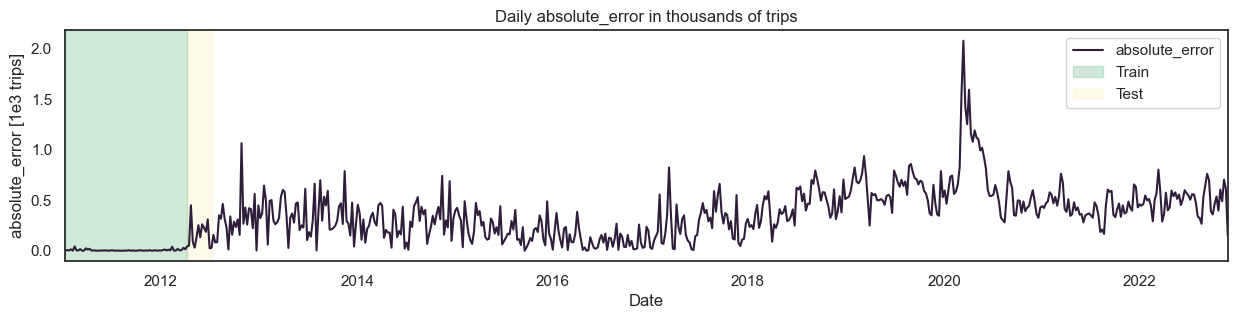

In [35]:
daily_demand = df.groupby('week')[['demand', 'predicted_demand']].sum() / 1000000
daily_demand['absolute_error'] = (daily_demand['demand'] - daily_demand['predicted_demand']).abs()
daily_demand.index = daily_demand.index.to_timestamp()

fig, ax = plt.subplots(figsize=(15, 3))
ax.set_title('Daily taxi demand in thousands of trips')
daily_demand[['demand', 'predicted_demand']].rolling(window=1).mean().plot(ax=ax, color=['blue', 'red'])
daily_demand[['demand', 'predicted_demand']].plot(ax=ax, alpha=0.125, legend=False, color=['blue', 'red'])
vspan(ax)
ax.set(xlabel='Date', ylabel='Demand [1e3 trips]')
plt.savefig('../../figures/taxi_true_demand_vs_predicted_timeseries.svg', format='svg', bbox_inches='tight')


fig, ax = plt.subplots(figsize=(15, 3))
ax.set_title('Daily absolute_error in thousands of trips')
daily_demand[['absolute_error']].plot(ax=ax, legend=False)
ax.set(xlabel='Date', ylabel='absolute_error [1e3 trips]')

vspan(ax)
plt.savefig('../../figures/taxi_weekly_absolute_error_timeseries.svg', format='svg', bbox_inches='tight')
plt.show()